# LLM from scratch 

We follow this [tutorial](https://medium.com/@msouza.os/llm-from-scratch-with-pytorch-9f21808c6319)

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re

import matplotlib.pyplot as plt

import tqdm

## Tokenization

**Idea**: need to make the machine able to read text. Since it can only understand numbers, need to _encode text into numbers_. Since humans can only understand text, we need to be able to _decode numbers into text_

=> need numeric representation of text 

1. split text into sequence of words (_tokens_)
2. for each word (_token_) in model vocabulrary, assign integer

There are several different models for tokenizers. Note that model performance during training will be affected by chosen tokenizer.

In [2]:
class Tokenizer:

    @staticmethod
    def create_vocab(dataset:str,mode='char',ukn=True)->dict[str:str]:
        """
        Create vocabulary

        :param dataset: Text data to be used to define vocabulary
        :type dataset: str

        :returns: (word) vocabulary  
        :rtype: dict[str:int]
        """

        # CREATE VOCABULRARY
        if mode == 'char':
            vocab = {tkn:idx for idx,tkn in enumerate(sorted(set(dataset)))}
        elif mode == 'word':
            pattern_ = re.compile(r'(?<=\w)(?=[^\w])|(?<=[^\w])(?=\w)|(?<=[^\w])(?=\s)|(?<=[^\w])(?=[^w])') # pattern splits string into words, spaces and special characters
            words_in_data = pattern_.split(dataset)
            vocab = {tkn:idx for idx,tkn in enumerate(sorted(set(words_in_data)))}

        # ADD UNKNOWN TOKEN
        if ukn:
            vocab['<ukn>'] = len(vocab)

        return vocab
    

    def __init__(self,vocab:dict[str,int],mode='char',ukn=True) -> None:
        """
        Initialize tokenizer

        :param vocab: vocabulary to intitalize
        :type vocab: dict[str:int]
        """
        self.mode = mode # mode: word or char
        self.ukn = ukn # <ukn> token
        self.vocab_encode = {str(k): int(v) for k, v in vocab.items()} # encode vocab: key:value = char:int
        self.vocab_decode = {v: k for k, v in self.vocab_encode.items()} # decode vocab key:value = int:char
        if self.mode == 'word':
            self.pattern = re.compile(r'(?<=\w)(?=[^\w])|(?<=[^\w])(?=\w)|(?<=[^\w])(?=\s)|(?<=[^\w])(?=[^w])')

    def encode(self,text:str):
        """
        Encode text in (lvl: character)

        :param text: Input text to encode
        :type text: str

        :returns: encoded text (list with token indices)
        :rtype: list[int]
        """

        if self.mode == 'word':
            text_ = self.pattern.split(text)
        else:
            text_ = text
        
        if self.ukn:
            encoded_txt = [self.vocab_encode.get(word,self.vocab_encode['<ukn>']) for word in text_]
        else:
            encoded_txt = [self.vocab_encode.get(word) for word in text_]

        return encoded_txt
    
    def decode(self,idxs:list[int]):
        """
        Decode a list of token indices

        :param idxs: List of token indices
        :type idxs: list[int]

        :returns: Decoded text
        :rtype: str
        """

        if self.ukn:
            decoded_txt = [self.vocab_decode.get(idx,'<ukn>') for idx in idxs]
        else:
            decoded_txt = [self.vocab_decode.get(idx) for idx in idxs]

        return ''.join(decoded_txt)

### Sanity Check

In [92]:
dataset = 'Hallo Welt! Wie geht es Dir?'
mode = 'char'

vocab = Tokenizer.create_vocab(dataset,mode=mode)

tokenize = Tokenizer(vocab,mode=mode)

test = 'Hallo Welt :)'

enc = tokenize.encode(test)
dec = tokenize.decode(enc)

print(f'{enc = }\n')
print(f'{dec = }')

enc = [4, 6, 11, 11, 12, 0, 5, 7, 11, 15, 0, 16, 16]

dec = 'Hallo Welt <ukn><ukn>'


### Markov Chain LLM

An easy implementation of a next-token-predictor using only the context of the previous token (like a Markov Chain)

In [ ]:
!curl https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -o TinyShakespeare.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  3225k      0 --:--:-- --:--:-- --:--:-- 3222k


In [18]:
with open("TinyShakespeare.txt","r") as file:
    text = file.read()


In [19]:
mode = 'char' # char vocabulary
ukn = False # omit <ukn> token

vocab = Tokenizer.create_vocab(text,mode,ukn)
vocab_size = len(vocab)

print(f"chars in vocab:\n {r''.join(list(vocab.keys()))}\n")

print(f'{vocab_size = }')

chars in vocab:
 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

vocab_size = 65


In [20]:
# PREPARING DATA
tokenize = Tokenizer(vocab,ukn=ukn)

encode = tokenize.encode
decode = lambda s: tokenize.decode(s.tolist()) # s tensor

data = torch.tensor(encode(text),dtype=int) # encoded text


# SPLIT TRAIN - VALDIATION
split = int(0.9*len(data))

data_train = data[:split]
data_val = data[split:]

context_size = 8
batch_size = 4 

context = data[:context_size]
target = data[1:context_size+1]

# DISPLAY CONTEXT AND TARGET (NEXT TOKEN IN SEQUENCE)
for t in range(context_size):
    context_ = decode(context)[:t+1]
    next_token = decode(target)[t]
    
    print(f'{context_ = :<15} {next_token = }')


context_ = F               next_token = 'i'
context_ = Fi              next_token = 'r'
context_ = Fir             next_token = 's'
context_ = Firs            next_token = 't'
context_ = First           next_token = ' '
context_ = First           next_token = 'C'
context_ = First C         next_token = 'i'
context_ = First Ci        next_token = 't'


In [4]:
def get_batch(split:str):
    """
    Grabs batch of context-chuncks from training / validation data

    :params split: which "split" (train / validation) of data to grab from
    :type split: str

    :returns: context and corresponding target predictions
    :rtype: tuple(torch.tensor,torch.tensor)
    """
    data = data_train if split == 'train' else data_val

    start = torch.randint(low=0,high=len(data) - context_size,size=(batch_size,)) # grab random starting points in data ( = rnd indices)

    context = torch.stack( [data[t:t+context_size] for t in start] ) 
    target = torch.stack( [data[t+1:t+1+context_size] for t in start] )

    return context, target


In [23]:
# TEST get_batch()
torch.manual_seed(57)
contexts, targets = get_batch('train')

print('Test get_batch():\n')
print(f'{contexts.shape = }')
print(f'{targets.shape = }')

Test get_batch():

contexts.shape = torch.Size([4, 8])
targets.shape = torch.Size([4, 8])


In [53]:
# THE MODEL
class MarkovChainLLM(nn.Module):

    def __init__(self,vocab_size):
        super().__init__()
        self.embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=vocab_size)  # embedding table 

    def forward(self,contexts,targets=None):
        # PREDICTIONS / LOGITS
        logits = self.embedding_table(contexts) # context = encoded characters = sequence of integers: dim (b,t,c) = (batch, time, channel)


        if targets == None:
            loss = None
        else:
            # RESHUFFLE TO HAND TO ENTROPY
            b,t,c = logits.shape
        
            logits = logits.view(b*t,c)
            y = targets.view(b*t)

            loss = F.cross_entropy(logits,y)
            
        return logits, loss
    
    def generate(self,idx,max_new_tokens):
        """
        Genereate new tokens.

        Idea:
        -----
        Perform a random (Markov Chain) walk in the vocabulrary based on transition probabilities stored in the embedding table.
        This means, one starts with a token and grabs the associated probabilities for the next token from the embedding table. 
        Then, sample and jump (predict) to the the next token according to those probabilities (i.e. via a 1-step multinomial distribution) and repeat.
        The Markov Property enters in the assumption that the context used to predict the next token is given **only** by the current token.

        Parameters:
        -----------
        idx: torch.tensor
            encoded starting context 

        max_new_tokens: int
            number of tokens to predict

        Returns:
        --------
        idx: list[int]
            list of new tokens (encoded predicted characters)
        """

        # idx.shape = (b,t) in current context
        # notation: b = batch dim, t = time dim (len context), c = channels (len vocab)

        for _ in range(max_new_tokens):

            # PREDICT
            logits, _ = self(idx) # if no target are specified, the forward method extract row `idx` from embedding table => (b,t,c)

            # MARKOV PROPERTY
            logits = logits[:,-1,:] # => (b,c)

            # TAKE RANDOM SAMPLE
            probas = F.softmax(logits,dim=-1) # softmax over channels dimension => shape (b,)
            

            next_idx = torch.multinomial(probas,num_samples=1) # pick token from vocab => (1,)

            idx = torch.cat((idx,next_idx),dim=1) # (b,t+1)

        return idx




In [44]:
# TEST MODEL
contexts, targets = get_batch('train')

model = MarkovChainLLM(vocab_size)

logits, loss = model(contexts,targets)


In [47]:
# TEST MarkovChainLLM.generate() BEFORE TRAINING
start = torch.zeros(1,1,dtype=torch.long)
max_new_tokens = 100

print('Test token generation before training:')
print(decode(model.generate(idx = start,max_new_tokens = max_new_tokens)[0]))

Test token generation before training:

NwFLgccgcTEZ-EcVTIak?qM'';o
P$O;aGQH-E3Y$cn;EHz,iwhtsBubkZKMKIIDnvgbxId -InrUCgcTgzXIn;Uv
YgzwZVkZ-k


In [50]:
def grab(x):
    """
    Grabs and detaches given torch.tensor
    """
    return x.detach()

100%|██████████| 10000/10000 [00:08<00:00, 1218.09it/s]


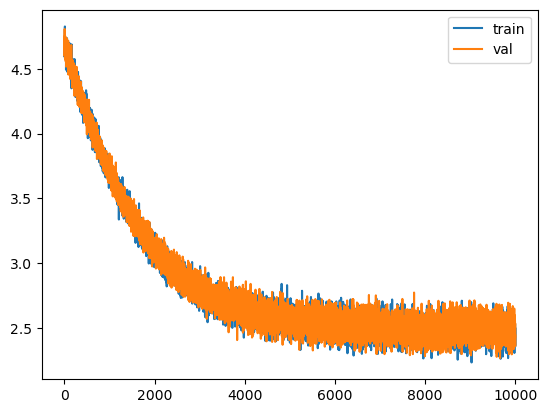

In [51]:
# TRAINING
alpha = 1e-3 # learning rate
optimizer = optim.AdamW(model.parameters(),lr = alpha) # optimizer

batch_size = 32

epochs = 10_000

losses_train = []
losses_val = []

for epoch in tqdm.tqdm(range(epochs)):
    optimizer.zero_grad()

    contexts_train, targets_train = get_batch('train')
    contexts_val, targets_val = get_batch('val')

    # FORWARD
    logits_train, loss_train = model(contexts_train,targets_train)

    # BACKPROPAGATION
    loss_train.backward()

    # UPDATE PARAMETERS
    optimizer.step()

    # VALIDATION
    with torch.no_grad():
        logits_val, loss_val = model(contexts_val,targets_val)


    losses_train.append(grab(loss_train))
    losses_val.append(grab(loss_val))


fig = plt.figure()
ax = fig.add_subplot()

ax.plot(losses_train,label = 'train')
ax.plot(losses_val,label = 'val')
ax.legend()


In [52]:
# TEST MarkovChainLLM.generate() AFTER TRAINING
start = torch.zeros(1,1,dtype=torch.long)
max_new_tokens = 100
print('Test token generation after training:')
print(decode(model.generate(idx = start, max_new_tokens = max_new_tokens)[0]))

Test token generation after training:

bl asherir s cthaCLLisw an-lo fotoo BOfou man:
CRDUEELLKI:

Thir lllofall den!'lyinfrtorshat oWilice


# The *Attention is all you need* Architecthure

## Embedding 

**Idea:** We want the computer to understand the symmantics (not only syntax). Thus we need to teach it what words (characters) are _similar_. To do so, we use vector represetnations (**embeddings**) of the tokens. These embeddings come with learnable parameters that can be adjusted during training to imporve the representation. The embedding is thus a map from the vocabulary $V$ to some vector space $X$: $E \colon V \to X$. If $\dim(V) = N$ (length of vodabulary) and $\dim(X) = d$, then the embedding is a _linear_ map $E \colon \mathbb{R}^N \to \mathbb{R}^d$ so a $N \times d$ matrix. 

Notice that the larger $d$, the more parameters can be learned and hence the more the model can learn more details about the dataset at the expense of computation time.


**Implementation:** 

1. Assign to each token a random vector of parameters (which will be learned during training). Assume that the length of the vocabulary is $N$, and we embedd into a vector space of dimension $d$, the embedding space will be $\mathbb{R}^N \times \mathbb{R}^d$ which can be represented as a matrix with $N$ rows and $d$ columns.

2. To compute similarity, use _cosine_ distance: for $x,y \in \mathbb{R}^d$, define their cosine-distance by $d(x,y) = \cos( \sphericalangle (x,y) ) \in [-1,1]$

Note that 

$$ \cos( \sphericalangle (x,y) ) = \frac{\langle x, y \rangle}{\lVert x \rVert \lVert y \rVert}$$ 

## Transformers

**!!** LLMs = Transformer based models

**Transformer model architecture:** [Attention is all you need](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)

1. composed of 1 _encoder_ and 1 _decoder_ block (using attention mechanism called _Scaled Dot-Product Attention_)

2. How they work
    * Encoder block: tries to analyze each word considering the entire text context
    * Decoder block: masks all future words at some specific position and uses only the _previous_ words available to analyze the current one
    * Main block: _Multi-Head Attention_ (!! key component of LLMs)

## Attention Mechanism 

### Scaled Dot-Product Attention

**Input:**
* Q: query = information we're trying to find (relationship between tokens)
* K: Key =  where you will find this information
* V: Value



**architecture:** 

```
Q --> |
      | MatMult --> Scale --> Mask(opt.) --> SoftMax --> |
K --> |                                                  |   
                                                         | -- MatMult -->
                                                         |
V ------------------------------------------------------>|
```


$Q,K,V$ are calculated by linear transformations (simple linear layers) from the embedded text. The workflow is roughly as follows: for $T \in Mat(\mathbb{R},N\times N)$

$\text{text (str)} \stackrel{E\;(\text{embedding})}{\longrightarrow} Q,K \in \mathbb{R}^N \times \mathbb{R}^d \stackrel{T}{\longrightarrow} Q',K' \in \mathbb{R}^N \times \mathbb{R}^d  \stackrel{Q K^t}{\longrightarrow} R \in \mathbb{R}^N \times \mathbb{R}^N$ 

The output of this sequence is a $N\times N$ matrix $R$ encoding the _relationship_ between our tokens. 

Next, we need to scale (to avoid 1-hot encoding) by $\sqrt{N}$ ($N$ is called the _embedding dimension_) and then feed it into a SoftMax function to normalize each value to (0,1) such that each row sums up to 1. This defines the so-called _attention_

$$A = \frac{Q K^t}{\sqrt{N}}$$

Finally, we need to multiply it with the $V$ to obtain a "vector representation" if the information we were looking for:

$$ \text{out} = A V$$ 

_Remark_: It seems to be custom to scale A by the _embedding size_ $d$

_NOTE_:  The attention mechanisim for transformers is trying to predict **every single token** in our sequence and not only the last one.
However, during training we actually want to predict only the next token given a sequence of tokens as _context_. We could even look at a Markov Chain by considering only the previous token to predict the next one. The problem is that the output $out = A V$ considers _all_ possible tokens: the entire attention matrix $A$ is used.
To overcome this problem, we mask $A$. We can multiply $A$ simply by a lower triangular matrix $M$ with all non-zero entries being 1. The mask then hides all consecutive tokens of all samples.





In [237]:
# IMPLEMENTATION
torch.random.manual_seed(seed=42)


# DATA
text = "Hi! I am Donald."
vocab = Tokenizer.create_vocab(text)
tokenize = Tokenizer(vocab)

tokens = tokenize.encode(text) # [4, 1, 0, 5, 0, 6, 0, 3, 2]
tokens.reverse()

# PARAMETERS
# vocab_size = max(tokens) + 1 # numbers of tokens (classes) to predict 
vocab_size = max(vocab.values())  #N = numbers of tokens (classes) to predict (last class is <ukn> but 0 based)
emb_dim = 3 # d = size of vecrep of each token
context = len(tokens) # context size of model

# LAYERS
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim) # tokens = (N,) -> (N,3)
query = nn.Linear(in_features=emb_dim, out_features=emb_dim, bias=False) # linear transformation on 2nd idx (N,3) -> (N,3) @ (3,3) = (N,3)
key = nn.Linear(in_features=emb_dim, out_features=emb_dim, bias=False)
value = nn.Linear(in_features=emb_dim, out_features=emb_dim, bias=False)

# MASK
ones = torch.ones(size=[context, context], dtype=torch.float)
mask = torch.tril(input=ones) # lower triangular matrix 

# TOKEN IDXS FOR POS EMBEDDING
tkn_idxs = torch.arange(context, dtype=torch.long)

# FORWARD PASS
t_tokens = torch.tensor(tokens).unsqueeze(dim=0) # (N,) -> (1,N)

x = embedding(t_tokens) # (1,N) -> (1,N,d) embedded vectors

B, T, C = x.size()

# apply linear transformation T
Q = query(x) # (1,N,d) -> (1,N,d) @ (1,d,d) = (1,N,d)
K = key(x) 
V = value(x) 

# matmul
QK = Q @ K.transpose(-2, -1) # (1,N,d) @ (1,d,N) -> (1,N,N)
A = QK  * C**-0.5 # attention matrix 
A.masked_fill_(mask[:T,:T] == 0, float("-inf")) # applying mask
A = F.softmax(input=A, dim=-1) # apply SoftMax: (1,N,N) normalizing to 0 and 1 in embedding dimension

out = A @ V # (1,N,N) @ (1,N,d) -> (1,N,d)

# print(f'{out = }\n') # new data representation
print(f'{out.size() = }\n') 

# x_before = x.detach().clone()
x_after = x.detach().clone()


out.size() = torch.Size([1, 9, 3])



In [235]:
print('x before reversing the order of the token sequence')
print(x_before)

x before reversing the order of the token sequence
tensor([[[-1.1109,  0.0418, -0.2516],
         [-2.1055,  0.6784,  1.0783],
         [ 1.9269,  1.4873,  0.9007],
         [ 0.8599, -0.3097, -0.3957],
         [ 1.9269,  1.4873,  0.9007],
         [ 0.8034, -0.6216, -0.5920],
         [ 1.9269,  1.4873,  0.9007],
         [-0.6866, -0.4934,  0.2415],
         [ 0.8008,  1.6806,  0.3559]]])


In [238]:
print('x after reversing the order of the token sequence')
print(x_after)

x after reversing the order of the token sequence
tensor([[[ 0.8008,  1.6806,  0.3559],
         [-0.6866, -0.4934,  0.2415],
         [ 1.9269,  1.4873,  0.9007],
         [ 0.8034, -0.6216, -0.5920],
         [ 1.9269,  1.4873,  0.9007],
         [ 0.8599, -0.3097, -0.3957],
         [ 1.9269,  1.4873,  0.9007],
         [-2.1055,  0.6784,  1.0783],
         [-1.1109,  0.0418, -0.2516]]])


We see that the entries in x _before_ and _after_ reversing the order of the input sequence of tokens are essentially the same up to orientation. 
The columns (same for rows) contain the same numbers but in reversed order, as seen below

In [271]:
x_before_col1 = [elem for elem in x_before[0][:,0]]
x_after_col1 = [elem for elem in x_after[0][:,0]]
x_after_col1.reverse()

print(f'before: {"after:":>15} {"diff:":>14}')
for i in range(len(x_before_col1)):
    print(f'{x_before_col1[i]: .3f} {x_after_col1[i]: >15.3f} {x_before_col1[i] - x_after_col1[i]: >15.3f}')


before:          after:          diff:
-1.111          -1.111           0.000
-2.106          -2.106           0.000
 1.927           1.927           0.000
 0.860           0.860           0.000
 1.927           1.927           0.000
 0.803           0.803           0.000
 1.927           1.927           0.000
-0.687          -0.687           0.000
 0.801           0.801           0.000


## Positional Encoding

Location of words in sentences matter.
The vector representation should thereofre depend on the order of the token sequence.

However, the attention mechanism above considers every token all at once in order to get a sense of _context_. Hence, we need to encode the positions by hand. This can be done by introducing another set of _positional_ parameters which can be learned. We simply define yet another embedding (of dimension context x emb_dim) and add it to our token embedding. 

In [273]:
# IMPLEMENTATION
torch.random.manual_seed(seed=42)


# DATA
text = "Hi! I am Donald."
vocab = Tokenizer.create_vocab(text)
tokenize = Tokenizer(vocab)

tokens = tokenize.encode(text) # [4, 1, 0, 5, 0, 6, 0, 3, 2]
tokens.reverse()

# PARAMETERS
# vocab_size = max(tokens) + 1 # numbers of tokens (classes) to predict 
vocab_size = max(vocab.values())  #N = numbers of tokens (classes) to predict (last class is <ukn> but 0 based)
emb_dim = 3 # d = size of vecrep of each token
context = len(tokens) # context size of model

# LAYERS
pos_emb = nn.Embedding(num_embeddings=context, embedding_dim=emb_dim) # !! positional encoding 
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim) # tokens = (N,) -> (N,3)
query = nn.Linear(in_features=emb_dim, out_features=emb_dim, bias=False) # linear transformation on 2nd idx (N,3) -> (N,3) @ (3,3) = (N,3)
key = nn.Linear(in_features=emb_dim, out_features=emb_dim, bias=False)
value = nn.Linear(in_features=emb_dim, out_features=emb_dim, bias=False)

# MASK
ones = torch.ones(size=[context, context], dtype=torch.float)
mask = torch.tril(input=ones) # lower triangular matrix 

# TOKEN IDXS FOR POS EMBEDDING
tkn_idxs = torch.arange(context, dtype=torch.long)

# FORWARD PASS
t_tokens = torch.tensor(tokens).unsqueeze(dim=0) # (N,) -> (1,N)

x = embedding(t_tokens) # (1,N) -> (1,N,d) embedded vectors
x += pos_emb(tkn_idxs) # !! add pos embeddings

B, T, C = x.size()

# apply linear transformation T
Q = query(x) # (1,N,d) -> (1,N,d) @ (1,d,d) = (1,N,d)
K = key(x) 
V = value(x) 

# matmul
QK = Q @ K.transpose(-2, -1) # (1,N,d) @ (1,d,N) -> (1,N,N)
A = QK  * C**-0.5 # attention matrix 
A.masked_fill_(mask[:T,:T] == 0, float("-inf")) # applying mask
A = F.softmax(input=A, dim=-1) # apply SoftMax: (1,N,N) normalizing to 0 and 1 in embedding dimension

out = A @ V # (1,N,N) @ (1,N,d) -> (1,N,d)

print(f'{out = }\n') # new data representation
print(f'{out.size() = }\n') 

# x_before = x.detach().clone()
x_after = x.detach().clone()


out = tensor([[[-3.1104, -0.4777, -2.1211],
         [-1.6634, -0.0585, -1.0139],
         [-0.8581, -0.0070, -0.5185],
         [ 0.0281,  0.2477,  0.1658],
         [-0.4765,  0.1084, -0.1927],
         [-0.0140,  0.1900,  0.1065],
         [ 0.0133,  0.1353,  0.1065],
         [ 0.1216,  0.0141,  0.0771],
         [ 0.0057,  0.0227,  0.0102]]], grad_fn=<UnsafeViewBackward0>)

out.size() = torch.Size([1, 9, 3])



Now, comparing x before and after, we see that we get truely different representations:

In [274]:
x_before_col1 = [elem for elem in x_before[0][:,0]]
x_after_col1 = [elem for elem in x_after[0][:,0]]
x_after_col1.reverse()

print(f'before: {"after:":>15} {"diff:":>14}')
for i in range(len(x_before_col1)):
    print(f'{x_before_col1[i]: .3f} {x_after_col1[i]: >15.3f} {x_before_col1[i] - x_after_col1[i]: >15.3f}')


before:          after:          diff:
 3.205          -0.280           3.484
-3.195          -1.152          -2.042
-0.889          -1.069           0.180
 1.705          -0.160           1.866
-1.956          -1.956           0.000
-0.859           1.007          -1.866
-1.069          -0.889          -0.180
 0.284          -1.759           2.042
-0.701           2.783          -3.484


# Misc

In [159]:
spltting_pattern = re.compile(r'(?<=\w)(?=[^\w])|(?<=[^\w])(?=\w)|(?<=[^\w])(?=\s)|(?<=[^\w])(?=[^w])')
foo = 'Hi!! My name is Donald. What is your name? :)'
res = spltting_pattern.split(foo)
print(res)




['Hi', '!', '!', ' ', 'My', ' ', 'name', ' ', 'is', ' ', 'Donald', '.', ' ', 'What', ' ', 'is', ' ', 'your', ' ', 'name', '?', ' ', ':', ')']
